a very quick implementation of object detection.


1. Get the pascal voc dataset.

In [87]:
from typing import Tuple, List
import numpy as np
import cv2
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets.voc import VOCDetection
from torchvision.models import detection
from torchvision.transforms import transforms
from matplotlib import pyplot as plt
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator


In [79]:
VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


HEIGHT = 448
WIDTH = 448


albument_transforms = A.Compose(
    [
        A.Resize(height=HEIGHT, width=WIDTH, always_apply=True),
        # A.RandomCrop(width=WIDTH, height=HEIGHT),
        # A.HorizontalFlip(p=0.5),
        # A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(always_apply=True),
        A.Lambda(image=lambda x, **kwargs: x / 255.0)
    ],
    bbox_params=A.BboxParams(
        format='pascal_voc',
        min_visibility=0.5,
        label_fields=['class_labels']
    )
)


def transform_targets_for_model(bboxes, classes):
    """
    boxes: FloatTensor[N, 4] x1y1x2y2
    labels: Int64Tensor[N]
    image_id:
    area:
    iscrowd:
    masks:
    keypoints:
    """
    return {
        'boxes': torch.FloatTensor(bboxes),
        'labels': torch.LongTensor(classes),
    }


def transform_targets_for_augmentation(targets: dict) -> Tuple[List[Tuple[int, int, int, int]], List[int]]:
    classes = []
    boxes = []
    for object in targets['annotation']['object']:
        class_index = VOC_CLASSES.index(object['name'])
        classes.append(class_index)

        box = object['bndbox']
        box = tuple(int(box[key]) for key in ['xmin', 'ymin', 'xmax', 'ymax'])
        boxes.append(box)

    return boxes, classes


def transforms_fn(image, targets):
    boxes, classes = transform_targets_for_augmentation(targets)

    transformed = albument_transforms(
        image=np.array(image),
        bboxes=boxes,
        class_labels=classes,
    )

    transformed_image = transformed['image']
    transformed_bboxes = transformed['bboxes']
    transformed_class_labels = transformed['class_labels']

    transformed_targets = transform_targets_for_model(
        transformed_bboxes, transformed_class_labels
    )
    return transformed_image, transformed_targets


def collate_fn_voc(batch: List[Tuple[torch.Tensor, dict]]) -> Tuple[list, Tuple[list, list]]:
    """
    :param batch: list of tuple of image and and dict targets
    :return: images are batched into a tensor, rest are lists
    """
    images = []
    targets = []
    for image, target in batch:
        images.append(image)
        targets.append(target)

    images = torch.stack(images)
    return images, targets


dataset_train = VOCDetection(
    root='../data',
    year='2012',
    image_set='train',
    download=False,
    transforms=transforms_fn,
)

dataloader_train = DataLoader(
    dataset_train,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn_voc,
)

for data in dataloader_train:
    x = data
    break

/opt/homebrew/Caskroom/miniforge/base/envs/dl/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:2387: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn(


In [80]:
x[0].shape

torch.Size([2, 3, 448, 448])

target is of the following shape:

```yaml

annotation:
  filename: 2009_004972.jpg
  folder: VOC2012
  object:
    - name: bicycle
      bndbox:
        xmax: 471
        xmin: 54
        ymax: 336
        ymin: 39
      difficult: 0
      occluded: 0
      pose: Left
      trucated: 0
  segmented: 0
  size:
    depth: 3
    height: 375
    width: 500
  source:
    annotation: PASCAL VOC2009
    database: The VOC2009 Database
    image: flickr
```

But it needs to be in this shape:

```yaml
boxese: FloatTensor[N, 4] x1y1x2y2
labels: Int64Tensor[N]
image_id:
area:
iscrowd:
masks:
keypoints:
```

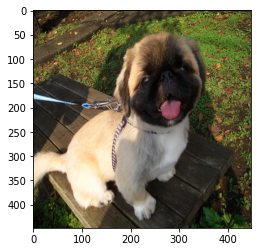

In [81]:
plt.imshow(x[0][0].moveaxis(0, -1))

In [82]:
backbone = torchvision.models.mobilenet_v2(pretrained=True).features

# FasterRCNN needs to know the number of
# output channels in a backbone.
# For mobilenet_v2, it's 1280
backbone.out_channels = 1280

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [ ]:
model = detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [83]:
model.train()
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [84]:
y = model(x[0], x[1])
y

{'loss_classifier': tensor(1.8646, grad_fn=<NllLossBackward>),
 'loss_box_reg': tensor(0.4296, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0835, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(0.0591, grad_fn=<DivBackward0>)}

In [85]:
model.eval()
y = model(x[0])
y

[{'boxes': tensor([[  0.0000,  42.8699, 350.9576, 428.5024],
          [ 58.8108, 231.5271, 439.0435, 441.9663],
          [205.5347, 249.9924, 417.2792, 432.1001],
          [322.5932, 158.7968, 377.1671, 263.0401],
          [  0.0000,  93.5196, 422.0069, 437.4358],
          [329.3998, 100.2442, 448.0000, 317.9648],
          [  9.1994, 160.1948, 320.6719, 423.6512],
          [ 72.1653, 149.4028, 395.4668, 439.7809],
          [137.3599,  50.3801, 359.4532, 372.4269],
          [344.0230, 335.2908, 436.6210, 440.0497],
          [101.5011, 182.2026, 174.1368, 205.5570],
          [371.6451, 256.8527, 391.9030, 270.9870]], grad_fn=<StackBackward>),
  'labels': tensor([18, 15, 15, 64, 15, 64, 17, 62, 18, 64, 87, 57]),
  'scores': tensor([0.9906, 0.6056, 0.5665, 0.3566, 0.3451, 0.2587, 0.1253, 0.1103, 0.1097,
          0.0908, 0.0661, 0.0572], grad_fn=<IndexBackward>)},
 {'boxes': tensor([[361.2238, 111.9676, 421.3593, 237.8182],
          [ 30.9581, 178.1720, 301.0175, 442.2974],
   

In [90]:
backbone = nn.Sequential(
    model.backbone
)

In [94]:
y = backbone(x[0])
y.keys()

odict_keys(['0', '1', '2', '3', 'pool'])

In [96]:
y['0'].shape, y['1'].shape, y['2'].shape, y['3'].shape, y['pool'].shape

(torch.Size([2, 256, 112, 112]),
 torch.Size([2, 256, 56, 56]),
 torch.Size([2, 256, 28, 28]),
 torch.Size([2, 256, 14, 14]),
 torch.Size([2, 256, 7, 7]))

In [102]:
anchor_generator = model.rpn.anchor_generator
z = anchor_generator(y)
z

TypeError: forward() missing 1 required positional argument: 'feature_maps'